In [1]:
import os
newestModel = True #If this is set to true it will use the newest model in the models folder and ignore modelToTest
modelToTest = ''
threads = 16 #Number of threads to use for multithreaded tasks
pathToModelFolder = '/home/jaredrussell/CPPMLGen/Models'
pathToDataFolder = '/home/jaredrussell/CPPTestingDataset'
#pathToDataFolder = '~/SPDataset/MiniTestingDataset'
#a folder inthe models folder contains the following files: model.h5, tokenizer.json commitHash.txt (For SCA-Tokenizer)
useCurrentSCATokenizer = '/home/jaredrussell/gitRepos/SCA-ML-grade/Model-Generation/SCA-Tokenizer' #If this is set to anything other than '' it will use the current SCA-Token in the SCA-Token folder and ignore the modelToTest

In [2]:
import os
import pickle
from keras.models import load_model
from keras.preprocessing.sequence import pad_sequences
import json
import threading as th
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import sys
import subprocess
import time
import datetime
import random
import math
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import tokenizer_from_json



catigoryInputModel = False


def homePath(path):
    if path[0] == '~':
        return os.path.join(os.path.expanduser("~"), path.strip("~/"))
    else:
        return path

pathToModelFolder = homePath(pathToModelFolder)
pathToDataFolder = homePath(pathToDataFolder)

def printProgressBar (iteration, total, prefix = '', suffix = '', decimals = 1, length = 100, fill = '█', printEnd = "\r"):
    """
    Call in a loop to create terminal progress bar
    @params:
        iteration   - Required  : current iteration (Int)
        total       - Required  : total iterations (Int)
        prefix      - Optional  : prefix string (Str)
        suffix      - Optional  : suffix string (Str)
        decimals    - Optional  : positive number of decimals in percent complete (Int)
        length      - Optional  : character length of bar (Int)
        fill        - Optional  : bar fill character (Str)
        printEnd    - Optional  : end character (e.g. "\r", "\r\n") (Str)
    """
    percent = ("{0:." + str(decimals) + "f}").format(100 * (iteration / float(total)))
    filledLength = int(length * iteration // total)
    bar = fill * filledLength + '-' * (length - filledLength)
    print(f'\r{prefix} |{bar}| {percent}% {suffix}', end = printEnd)
    # Print New Line on Complete
    if iteration == total: 
        print()


def searchFileName(path, fileName):
    filesToDo = []
    for root, dirs, files in os.walk(path):
        for file in files:
            if file == fileName:
                    filesToDo.append(os.path.join(root, file).split(path)[1])
    return filesToDo



2023-11-29 18:31:15.649790: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-29 18:31:15.685292: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-29 18:31:15.685323: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-29 18:31:15.686686: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-29 18:31:15.692335: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-29 18:31:15.692832: I tensorflow/core/platform/cpu_feature_guard.cc:1

In [3]:
#File Loading

import sys
sys.path.append('./SCA-Tokenizer/')
sys.path.append('./TokenCatigoryGenerator')
import TokenizerManager
import TokenCatigoryApplier


if newestModel:
    models = os.listdir(pathToModelFolder)
    models.sort()
    modelToTest = models[-1]
    print("Using newest model: " + modelToTest)
else:
    print("Using model: " + modelToTest)
model = load_model(pathToModelFolder + '/' +modelToTest + '/model.h5')
print (model.summary())

#load tokenizer from json that used the .tokenizer.save() function
#check if it's .json or .pkl
if os.path.isfile(pathToModelFolder + '/' + modelToTest + '/tokenizer.pkl'):
    with open(pathToModelFolder + '/' + modelToTest + '/tokenizer.pkl', 'rb') as f:
        tokenizerModel = pickle.load(f)
else:
    with open(pathToModelFolder + '/' + modelToTest + '/tokenizer.json') as f:
        tokenizerModel = tokenizer_from_json(f.read())

#check if groupings are being used 
# check if GroupDict.npy exists
if os.path.isfile(pathToModelFolder + '/' + modelToTest + '/GroupDict.npy'):
    catigoryInputModel = True
    print("Using catigory input model")
    groupDict = np.load(pathToModelFolder + '/' + modelToTest + '/GroupDict.npy', allow_pickle=True).item()
    print(groupDict)


Using newest model: 2023-11-29_18-20-03-069565
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 500, 64)           51264     
                                                                 
 conv1d_4 (Conv1D)           (None, 498, 64)           12352     
                                                                 
 global_max_pooling1d_4 (Gl  (None, 64)                0         
 obalMaxPooling1D)                                               
                                                                 
 reshape_4 (Reshape)         (None, 1, 64)             0         
                                                                 
 bidirectional_8 (Bidirecti  (None, 1, 128)            66048     
 onal)                                                           
                                                                 
 dropou

In [4]:


dfTokens = TokenizerManager.tokenStart(pathToDataFolder, tokenizer=tokenizerModel, multiThreadProcessing = False)

if catigoryInputModel:
    dfCatigories = TokenCatigoryApplier.translateTokens(groupDict, dfTokens)


    


completed folder index
Progressing (Not Multithreaded): |██████████████████████████████████████████████████| 100.0% Complete
Finishing
Tokenizing
                                               tokenCode  \
0       45 15 133 82 30 33 14 15 2 1 15 276 2 116 1 1...   
1       28 28 28 28 28 28 28 28 16 208 2 18 1 5 9 579...   
2       28 28 28 28 28 28 28 28 28 16 208 2 16 534 1 ...   
3       28 28 28 28 28 28 28 28 28 16 208 2 16 534 1 ...   
4       28 28 28 28 28 28 28 28 16 208 2 18 1 5 9 579...   
...                                                  ...   
35957   9 9 9 9 9 276 2 116 1 2 85 1 9 9 389 14 453 2...   
35958   511 2 1 511 511 276 2 116 1 42 2 1 511 30 348...   
35959   511 511 511 511 30 31 456 195 30 20 511 195 3...   
35960   511 2 1 511 511 276 2 116 1 42 2 1 511 30 348...   
35961   511 511 28 28 28 183 5 9 104 627 143 3 627 14...   

                                                    Path  
0      /3486120/stm32-nucleo-test/system/src/newlib/_...  
1      /3486120

In [5]:
#Grading Code
sys.path.append('../Auto-Grader/')
import Grader
#prevent warnings from printing
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
dfGrades = Grader.bootstrap(pathToDataFolder)

35791ssing Files |█████████████████████████████████████████████████-| 98.0% Complete
       fileGrade                                               Path
0           31.8  /3486120/stm32-nucleo-test/system/src/newlib/_...
1           31.8  /3486120/soccer_strategy/src/communication/Rob...
2           31.8  /3486120/soccer_strategy/src/communication/Rob...
3           31.8  /3486120/soccer_strategy/src/communication/Rob...
4           31.8  /3486120/soccer_strategy/src/communication/Rob...
...          ...                                                ...
35786       71.0  /3487007/external/include/boost/asio/impl/src....
35787       55.0  /3487007/external/include/glm/detail/dummy.cpp...
35788       68.0  /3487007/external/include/glm/detail/dummy.cpp...
35789       55.0  /3487007/external/include/glm/detail/glm.cpp/0...
35790       68.0  /3487007/external/include/glm/detail/glm.cpp/1...

[35791 rows x 2 columns]
Time Taken: 6.287755250930786


In [6]:
combinedDF = pd.merge(dfGrades, dfTokens, on = "Path")


In [7]:
#get max length of tokens from model
maxLen = model.layers[0].input_shape[1]
#combinedDF = combinedDF[combinedDF["tokenCode"].apply(lambda x: len(x)) <= maxLen]

#FOR TESTING, REDUCE TOKEN SIZE WHEN OVER maxLen
combinedDF["tokenCode"] = combinedDF["tokenCode"].apply(lambda x: [int(i) for i in x.split()[:maxLen]])
#reset index
combinedDF = combinedDF.reset_index(drop=True)
#Pad the sequences
combinedDF["tokenCode"] = pad_sequences(combinedDF["tokenCode"], maxlen = maxLen, padding = "post", truncating = "post").tolist()

if catigoryInputModel:
    combinedDF["tokenCatigory"] = pad_sequences(combinedDF["tokenCatigory"], maxlen = maxLen, padding = "post", truncating = "post").tolist()

ValueError: invalid literal for int() with base 10: ' 28 28 28 28 28 28 28 28 28 16 208 2 16 534 1 5 7 2 534 34 47 1 5 219 13 11 13 13 11 13 111 3 10 8 3 6 55 2 1 3 9 14 207 46 53 2 1 3 7 2 2 1 1 5 9 14 207 590 14 598 46 53 545 3 545 13 2 1 3 2 2 1 1 3

In [8]:

#add new colum to combinedDF for the model prediction
combinedDF["predictedGrade"] = None
showMessage = True


"""
    for i, row in combinedDF.iterrows():
        if combinedDF["predictedGrade"][i] == None:
            combinedDF.loc[i, "predictedGrade"] = model.predict(np.array(row["tokenCode"]).reshape(1, -1))
            if showMessage:
                printProgressBar(i, len(combinedDF), prefix = 'Progress:', suffix = 'Complete', length = 50)
            print(np.array(np.array(row["tokenCode"]).reshape(1, -1)))
            break
"""
    #INSTEAD OF ITTERATING FEED THE WHOLE LIST
combinedDF["predictedGrade"] = model.predict(np.array(combinedDF["tokenCode"].tolist()))


#make dir if it doesn't exist
if not os.path.exists(homePath("~/SPGenerations/") + '/' + "testingData" + '/' + modelToTest):
    os.makedirs(homePath("~/SPGenerations/") + '/' + "testingData" + '/' + modelToTest)



combinedDF.to_pickle(homePath("~/SPGenerations/") + '/' + "testingData" + '/' + modelToTest + '/combinedDF.pkl')
dataSetVersion = pathToDataFolder

#write that to a file
with open(homePath("~/SPGenerations/") + '/' + "testingData" + '/' + modelToTest + '/dataSetVersion.txt', 'w') as file:
    file.write(dataSetVersion)
    
        



660/660 [==============================] - 3s 4ms/step


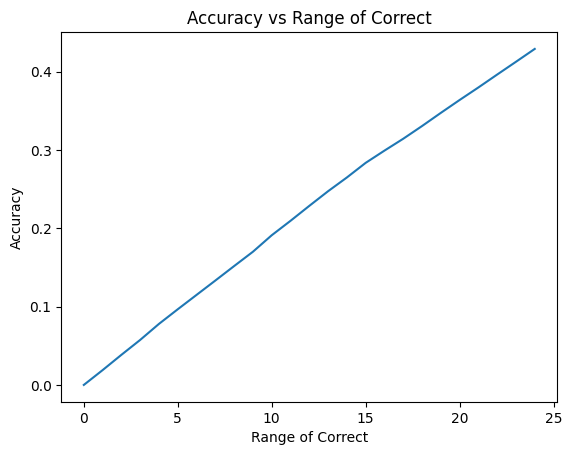

In [9]:
#check accuracy
correct = 0
total = 0


def getGradeRange(rangeofCorrect):
    correct = 0
    total = 0
    for i in combinedDF.index:
        if (combinedDF.at[i, "predictedGrade"] <= combinedDF.at[i, "fileGrade"] + rangeofCorrect and combinedDF.at[i, "predictedGrade"] >= combinedDF.at[i, "fileGrade"] - rangeofCorrect):
            correct += 1
        total += 1
    return correct, total



#generate a graph
import matplotlib.pyplot as plt
import numpy as np

x = np.arange(0, 25, 1)
y = []
for i in x:
    correct, total = getGradeRange(i)
    y.append(correct/total)
plt.plot(x, y)
plt.xlabel('Range of Correct')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Range of Correct')
plt.show()




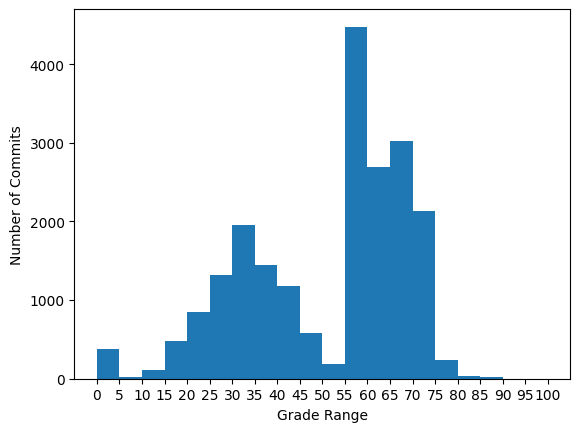

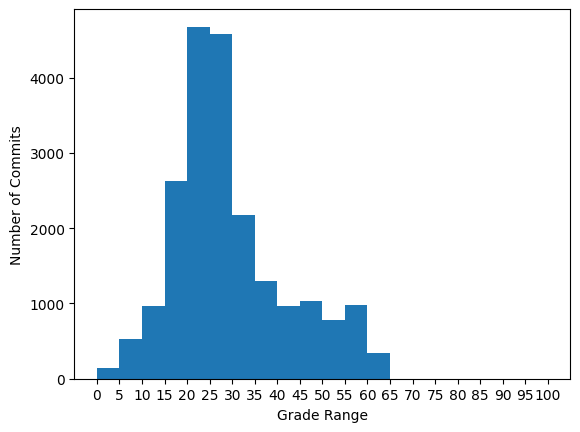

In [10]:
#generate graph showing range of grades
graph = plt.hist(combinedDF['fileGrade'], bins=20, range=(0, 100))
plt.xticks([0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100])
plt.xlabel("Grade Range")
plt.ylabel("Number of Commits")
plt.show()

graph = plt.hist(combinedDF['predictedGrade'], bins=20, range=(0, 100))
plt.xticks([0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100])
plt.xlabel("Grade Range")
plt.ylabel("Number of Commits")
plt.show()

In [11]:
incriments = 20
rangeofCorrect = 5

#break up the data into incriments
for i in range(incriments):
    #get the data for the incriments
    incrimentsDF = combinedDF[(combinedDF["fileGrade"] >= i * 100 / incriments) & (combinedDF["fileGrade"] < (i + 1) * 100 / incriments)]
    #get the accuracy for the incriments
    correct = 0
    total = 0
    for j in incrimentsDF.index:
        if (incrimentsDF.at[j, "predictedGrade"] <= incrimentsDF.at[j, "fileGrade"] + rangeofCorrect and incrimentsDF.at[j, "predictedGrade"] >= incrimentsDF.at[j, "fileGrade"] - rangeofCorrect):
            correct += 1
        total += 1
    #print the accuracy
    if(total != 0):
        print ("Accuracy for incriments " + str(i * 100 / incriments) + "% - " + str((i + 1) * 100 / incriments) + "%: " + str(correct/total * 100) + "%")


Accuracy for incriments 0.0% - 5.0%: 0.0%
Accuracy for incriments 5.0% - 10.0%: 10.0%
Accuracy for incriments 10.0% - 15.0%: 23.47826086956522%
Accuracy for incriments 15.0% - 20.0%: 34.177215189873415%
Accuracy for incriments 20.0% - 25.0%: 30.128956623681123%
Accuracy for incriments 25.0% - 30.0%: 31.359149582384205%
Accuracy for incriments 30.0% - 35.0%: 20.523345305284764%
Accuracy for incriments 35.0% - 40.0%: 15.880721220527047%
Accuracy for incriments 40.0% - 45.0%: 11.167945439045184%
Accuracy for incriments 45.0% - 50.0%: 12.45674740484429%
Accuracy for incriments 50.0% - 55.0%: 10.92896174863388%
Accuracy for incriments 55.0% - 60.0%: 5.9861514406968945%
Accuracy for incriments 60.0% - 65.0%: 1.630837657524092%
Accuracy for incriments 65.0% - 70.0%: 0.4626569729015202%
Accuracy for incriments 70.0% - 75.0%: 0.0%
Accuracy for incriments 75.0% - 80.0%: 0.0%
Accuracy for incriments 80.0% - 85.0%: 0.0%
Accuracy for incriments 85.0% - 90.0%: 0.0%


In [12]:
#comparitive commits tests

#Make an array of dataframes which are created from combinedDF, and are split by their original file

#Get the list of files
files = combinedDF["Path"]


#split all the files by the last / and get the first element of the split

files = [file.rsplit("/",1)[0] for file in files]
#remove duplicates
files = list(dict.fromkeys(files))

#reset index

#make an array of dataframes
dataframes = []
for i in range(len(files)):
    dataframes.append([])
for i in combinedDF.index:
    #get index of files where the file name is the same as the current file name
    index = files.index(combinedDF.at[i, "Path"].rsplit("/",1)[0])
    dataframes[index].append(combinedDF.iloc[i])

In [13]:
#per file commit simple test, checks if the previous commit is less than or equal to the current commit
correct = 0
equal = 0
total = 0
for dataframe in dataframes:
    for i in range(1, len(dataframe)):
        #make sure that the length of the dataframe is greater than 1
        if (dataframe[i]["predictedGrade"] > dataframe[i - 1]["predictedGrade"]):
            correct += 1
            total += 1
        elif (dataframe[i]["predictedGrade"] == dataframe[i - 1]["predictedGrade"]):
            equal += 1
        else:
            total += 1
print ("Accuracy for per commit simple test: " + str(correct/total * 100) + "%")

Accuracy for per commit simple test: 51.953710006807356%


Average correct score: 3.0853512871315396
Average incorrect score: -3.171015366443192
Accuracy for per file commit gap test of size 1 : 51.953710006807356%
Average correct score: 3.5519219760108895
Average incorrect score: -3.6880584073525955
Accuracy for per file commit gap test of size 2 : 51.028525968860095%
Average correct score: 4.018713932523001
Average incorrect score: -4.130727696495004
Accuracy for per file commit gap test of size 3 : 50.34029038112523%
Average correct score: 4.437751700660354
Average incorrect score: -4.550198267558243
Accuracy for per file commit gap test of size 4 : 49.76610291471752%
Average correct score: 4.906965395568772
Average incorrect score: -4.9138272209327765
Accuracy for per file commit gap test of size 5 : 49.31595250387197%
Average correct score: 5.276798602964965
Average incorrect score: -5.242611089531256
Accuracy for per file commit gap test of size 6 : 49.19433935827379%
Average correct score: 5.588241209951186
Average incorrect score: -5.5

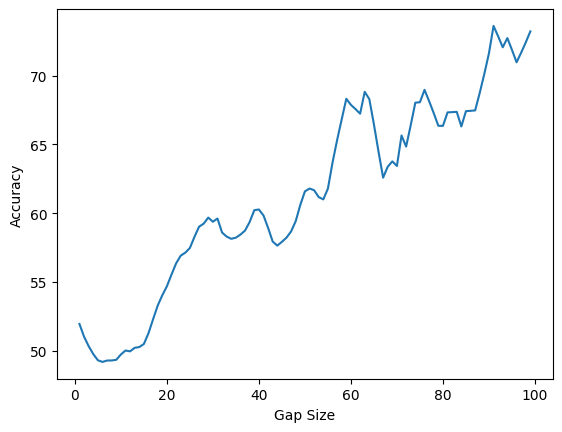

In [14]:
#per file commit gap test, checks if the previous commit is less than or equal to the current commit in a gap of 10

def gapTest(gap):
    correct = 0
    equal = 0
    total = 0
    avgCorrectScore = 0
    avgIncorrectScore = 0
    for dataframe in dataframes:
        for i in range(gap, len(dataframe)):
            #make sure that the length of the dataframe is greater than 1
            if (dataframe[i]["predictedGrade"] > dataframe[i - gap]["predictedGrade"]):
                correct += 1
                avgCorrectScore += dataframe[i]["predictedGrade"] - dataframe[i - gap]["predictedGrade"]
                total += 1
            elif (dataframe[i]["predictedGrade"] == dataframe[i - gap]["predictedGrade"]):
                equal += 1
            else:
                avgIncorrectScore += dataframe[i]["predictedGrade"] - dataframe[i - gap]["predictedGrade"]
                total += 1
    if (total != 0):
        avgCorrectScore /= correct
        try:
            avgIncorrectScore /= total - correct
        except:
            avgIncorrectScore = 0
        print ("Average correct score: " + str(avgCorrectScore))
        print ("Average incorrect score: " + str(avgIncorrectScore))
    if (total == 0):
        print ("This data is junk")
    print ("Accuracy for per file commit gap test of size " + str(gap) + " : " + str(correct/total * 100) + "%")

    return correct/total * 100 


for i in range(1, 100):
    gapTest(i)

#graph this
x = []
y = []
for i in range(1, 100):
    x.append(i)
    y.append(gapTest(i))
plt.plot(x, y)
plt.xlabel("Gap Size")
plt.ylabel("Accuracy")
plt.show()
